## Random Forests

In [1]:
# Setup Libraries if needed
import pandas as pd
import sklearn
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.pyplot.style.use('ggplot')

In [2]:
# import the training data
training = pd.read_csv('../DATA/training.csv', index_col='idx')

# view the data
training.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
idx,,,,,,,,,,,
1,1,0.766127,45,2,0.802982,9120,13,0,6,0,2
2,0,0.957151,40,0,0.121876,2600,4,0,0,0,1
3,0,0.658180,38,1,0.085113,3042,2,1,0,0,0
4,0,0.233810,30,0,0.036050,3300,5,0,0,0,0
5,0,0.907239,49,1,0.024926,63588,7,0,1,0,0


In [3]:
# Import SciKit Learn functions
from sklearn.metrics import roc_curve, auc , roc_auc_score, confusion_matrix, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import grid_search

In [4]:
# Split the target from the input variables
X = training.iloc[:, 1:]
y = training.iloc[:, 0]

# Now, split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

In [5]:
from datetime import datetime
startTime = datetime.now()

parameters = { 
    'n_estimators': [700,1000,1500,2000,3000,3500,4000,4500],
    'max_features': ['auto', 'log2'],
    }
clftree = grid_search.GridSearchCV(RandomForestClassifier(criterion='gini', oob_score=True), parameters, n_jobs=-1,
                                  scoring='roc_auc',refit=True)

clftree.fit(X_train, y_train)
tree_model = clftree.best_estimator_
print (clftree.best_score_, clftree.best_params_) 

print datetime.now() - startTime

(0.84964541162290064, {'max_features': 'auto', 'n_estimators': 3000})
0:43:48.766703


The Grid above was run on EC2 to save my poor computer from CPU overload. The results of the grid search  showed a negiible improvement on the AUC score. Nevertheless, we well train a model using the same specification on the entire training set and then predict the test set.

In [6]:
# Fit the optimal configuration to the training set and then 
# Look at the accuracy metrics
from datetime import datetime
startTime = datetime.now()

theForest = RandomForestClassifier(criterion='gini', oob_score=True ,n_estimators=3000,max_features='auto',
                                  n_jobs=-1) 

theForest.fit(X_train,y_train)

# Fit the decision tree classifier
theForest.predict(X_test)

tree_preds = theForest.predict_proba(X_test)[:, 1]

# Look at the accuracy metrics
print "The area under the curve is", roc_auc_score(y_test,tree_preds)
print theForest.oob_score_ 

print datetime.now() - startTime

The area under the curve is 0.849089687913
0.936097777778
0:01:49.087623


In [7]:
# Predict the test set
# import the test data
test = pd.read_csv('../DATA/test.csv', index_col='idx')

X_ = test.iloc[:, 1:]

In [8]:
from datetime import datetime
startTime = datetime.now()
# Final training on entire set
theForest1 = RandomForestClassifier(criterion='gini', oob_score=True ,n_estimators=3000,max_features='auto',
                                  n_jobs=-1) 

theForest1.fit(X,y)

# Fit the decision tree classifier
theForest1.predict(X_)

tree_preds = theForest1.predict_proba(X_)[:, 1]

df = pd.DataFrame(tree_preds)

print datetime.now() - startTime

0:02:47.881558


In [9]:
print "The Out-of-Bag Score is" , theForest1.oob_score_ 

The Out-of-Bag Score is 0.935693333333


In [11]:
df.to_csv('preds_6.csv')

## Outcome of Private Score Submission: AUC = 0.852720

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

In [11]:
tree_preds = theForest.predict_proba(X_test)[:, 1]

roc_auc_score(y_test,tree_preds)

0.84908968791326422

In [12]:
actual = np.array(y_test)
predictions = np.array(tree_preds)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

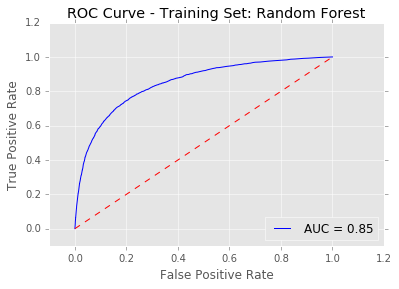

In [13]:
# ROC AUC graph
font = {'size'   : 10}
plt.rc('font', **font)
plt.title('ROC Curve - Training Set: Random Forest')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

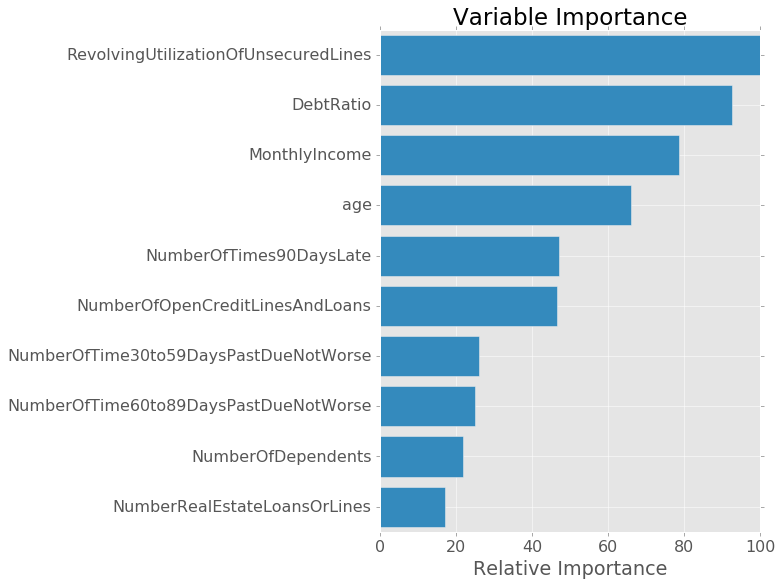

In [14]:
plt.figure(figsize=(6 *2.5,9))

feature_importance = theForest.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
font = {
        'size'   : 16}

plt.rc('font', **font)
plt.show()